# Lead Time Model

### Loading Modules 

In [85]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

### Loading Data

In [88]:
train=pd.read_csv('final_leadtimeData_train.csv')
test=pd.read_csv('final_leadtimeData_test.csv')
train

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,neighbor_outage_impact,wfo_influence,lat_grid,lon_grid,grid_density,data_source_reliability,month_sin,grid_load_proxy,DAMAGE_PROPERTY_MEAN,DAMAGE_CROPS_MEAN
0,201501,1,1508,201501,1,1509,92680,555384,GEORGIA,13,...,0.0,2500,32.0,-81.0,692,0.858972,5.000000e-01,726.915655,1.140806e+04,0.000000
1,201501,1,1510,201501,1,1511,92680,555385,GEORGIA,13,...,0.0,2500,32.0,-81.0,692,0.858972,5.000000e-01,726.915655,1.140806e+04,0.000000
2,201501,2,1300,201501,2,1500,92218,552499,TEXAS,48,...,0.0,1917,32.0,-102.0,500,0.858972,5.000000e-01,4122.991862,1.201420e+06,0.000000
3,201501,2,1722,201501,2,1842,92063,551600,HAWAII,15,...,0.0,1033,22.0,-160.0,76,0.858972,5.000000e-01,1513.076476,3.540667e+05,0.000000
4,201501,2,1849,201501,3,345,92063,551601,HAWAII,15,...,0.0,1033,21.0,-157.0,169,0.858972,5.000000e-01,1513.076476,5.308219e+04,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261344,202312,28,230,202312,28,400,187876,1154211,PENNSYLVANIA,42,...,0.0,6580,40.0,-75.0,2124,0.858972,-2.449294e-16,1024.005365,9.662212e+04,3861.003861
261345,202312,28,230,202312,28,500,187876,1154210,PENNSYLVANIA,42,...,0.0,6580,40.0,-75.0,2124,0.858972,-2.449294e-16,1024.005365,9.662212e+04,3861.003861
261346,202312,28,254,202312,28,500,187878,1154218,NEW JERSEY,34,...,0.0,6580,41.0,-74.0,1586,0.858972,-2.449294e-16,931.512511,4.946315e+04,0.049261
261347,202312,28,700,202312,28,1300,187878,1153863,NEW JERSEY,34,...,0.0,6580,41.0,-75.0,1029,0.858972,-2.449294e-16,931.512511,5.037719e+05,67114.161074


### Construct "leadtime" 

In [89]:
train['run_start_time_mean'] = pd.to_datetime(train['run_start_time_mean'])
train['BEGIN'] = pd.to_datetime(train['BEGIN'])
train['interval_count'] = pd.to_numeric(train['interval_count'], errors='coerce')
train['leadtime'] = (train['run_start_time_mean'] - train['BEGIN']).dt.total_seconds() / 3600  # 转为小时
train['leadtime'] = train['leadtime'] 
train['leadtime'].replace([np.inf, -np.inf], np.nan, inplace=True)
train['leadtime'].fillna(0, inplace=True)  # 或使用其他方式填补

/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/2955977813.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['leadtime'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/2955977813.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are s

### Drop all rows which has no leadtime

In [ ]:
# Ensure correct data types
test['run_start_time_mean'] = pd.to_datetime(test['run_start_time_mean'])
test['BEGIN'] = pd.to_datetime(test['BEGIN'])
test['interval_count'] = pd.to_numeric(test['interval_count'], errors='coerce')

# Calculate lead time (in hours)
test['leadtime'] = (test['run_start_time_mean'] - test['BEGIN']).dt.total_seconds() / 3600
test['leadtime'] = test['leadtime']  # Redundant, but harmless

# Replace infinite values and fill missing values
test['leadtime'].replace([np.inf, -np.inf], np.nan, inplace=True)
test['leadtime'].fillna(0, inplace=True)

# Apply to train: mark lagging records and filter out non-lagging ones
train['lagging'] = np.where(train['leadtime'] == 0, 0, 1)
train = train[train['lagging'] != 0]

# Apply to test: mark lagging records and filter out non-lagging ones
test['lagging'] = np.where(test['leadtime'] == 0, 0, 1)
test = test[test['lagging'] != 0]


/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/1865564744.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['leadtime'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/1865564744.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

### Categorical data embedding and concatanate with numerical data

In [92]:
categorical_cols = train.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if not col.startswith('END')]
from sklearn.preprocessing import LabelEncoder


train_embed = train.copy()
label_encoders = {}

for col in categorical_cols:
    train_embed[col] = train_embed[col].fillna('NA')  
    le = LabelEncoder()
    train_embed[col] = le.fit_transform(train_embed[col])
    label_encoders[col] = le  


X_train_embed = torch.tensor(train_embed[categorical_cols].values, dtype=torch.long)

test_embed = test.copy()

for col in categorical_cols:
    test_embed[col] = test_embed[col].fillna('NA')
    le = label_encoders[col]  # 使用训练时的编码器
    test_embed[col] = test_embed[col].apply(lambda x: x if x in le.classes_ else 'NA')  # 保证未知值不会报错
    if 'NA' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'NA')  # 添加 'NA' 到编码器
    test_embed[col] = le.transform(test_embed[col])

X_test_embed = torch.tensor(test_embed[categorical_cols].values, dtype=torch.long)

In [93]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numeric_cols if col != 'leadtime']

X_train_numerical = train[numeric_cols].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train_numerical)


X_test_numerical = test[numeric_cols].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_test_numerical = scaler.fit_transform(X_test_numerical)

/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/dee

### Convert to Tensor and drop NA and INF values

In [ ]:
import torch

# Concatenate numerical and embedding input features
X_train = torch.cat((torch.tensor(X_train_embed, dtype=torch.long), 
                     torch.tensor(X_train_numerical, dtype=torch.float32)), dim=1)
X_test = torch.cat((torch.tensor(X_test_embed, dtype=torch.long), 
                    torch.tensor(X_test_numerical, dtype=torch.float32)), dim=1)

# Convert target 'leadtime' to float32 NumPy array and then to tensor
y_train = train['leadtime'].astype(np.float32).values
y_train = torch.tensor(y_train, dtype=torch.float32)

y_test = test['leadtime'].astype(np.float32).values
y_test = torch.tensor(y_test, dtype=torch.float32)

# Replace NaNs and infinities in input and target tensors
X_train = torch.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
y_train = torch.nan_to_num(y_train, nan=0.0, posinf=1e6, neginf=-1e6)
X_test = torch.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)
y_test = torch.nan_to_num(y_test, nan=0.0, posinf=1e6, neginf=-1e6)


/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/1237325726.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train= torch.cat((torch.tensor(X_train_embed, dtype=torch.long), torch.tensor(X_train_numerical, dtype=torch.float32)), dim=1)
/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/1237325726.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test= torch.cat((torch.tensor(X_test_embed, dtype=torch.long), torch.tensor(X_test_numerical, dtype=torch.float32)), dim=1)


### Model Training and Evaluation

Epoch 1, Train Loss: 18701.5911
Epoch 2, Train Loss: 3426.0654
Epoch 3, Train Loss: 3003.7246
Epoch 4, Train Loss: 2842.8350
Epoch 5, Train Loss: 2719.4610
Epoch 6, Train Loss: 2680.6988
Epoch 7, Train Loss: 2620.1916
Epoch 8, Train Loss: 2591.9447
Epoch 9, Train Loss: 2574.0421
Epoch 10, Train Loss: 2556.2527
Epoch 11, Train Loss: 2503.6806
Epoch 12, Train Loss: 2497.7342
Epoch 13, Train Loss: 2458.7464
Epoch 14, Train Loss: 2444.2473
Epoch 15, Train Loss: 2432.0186
Epoch 16, Train Loss: 2391.1547
Epoch 17, Train Loss: 2388.8731
Epoch 18, Train Loss: 2384.3844
Epoch 19, Train Loss: 2354.5389
Epoch 20, Train Loss: 2332.0967
Epoch 21, Train Loss: 2300.1309
Epoch 22, Train Loss: 2276.9206
Epoch 23, Train Loss: 2237.7803
Epoch 24, Train Loss: 2216.5192
Epoch 25, Train Loss: 2175.4996
Epoch 26, Train Loss: 2187.4140
Epoch 27, Train Loss: 2135.5803
Epoch 28, Train Loss: 2087.3174
Epoch 29, Train Loss: 2083.3434
Epoch 30, Train Loss: 2013.6295
Epoch 31, Train Loss: 1959.6683
Epoch 32, Train 

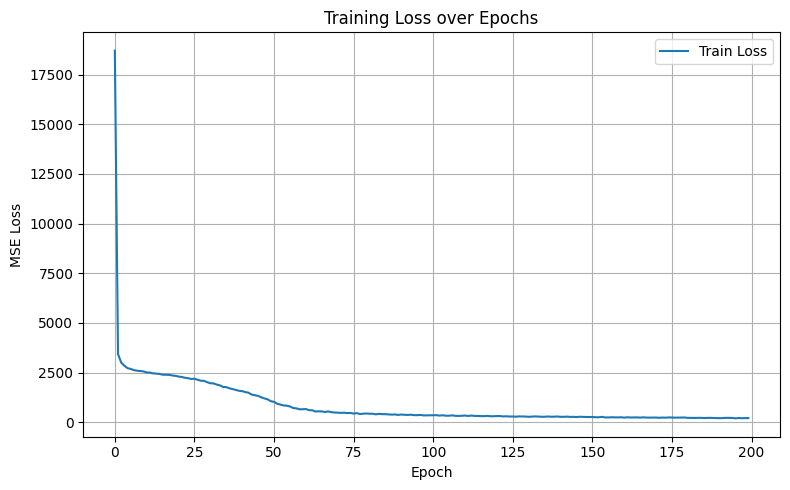

In [ ]:
def train_and_evaluate_model_with_dataloader(X_train, y_train, X_test, y_test, input_dim, batch_size=32, n_epochs=100):

    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    class MLP(nn.Module):
        def __init__(self, input_dim):
            super(MLP, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.layers(x)

    model = MLP(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)


    train_losses = []
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        
        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}")


    model.eval()
    test_predictions = []
    test_true = []
    test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.float())
            test_loss += loss.item() * X_batch.size(0)
            test_predictions.append(outputs.squeeze().cpu().numpy())
            test_true.append(y_batch.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_predictions = np.concatenate(test_predictions)
    test_true = np.concatenate(test_true)
    
    mse = mean_squared_error(test_true, test_predictions)
    mae = mean_absolute_error(test_true, test_predictions)
    r2 = r2_score(test_true, test_predictions)
    # rmse = mean_squared_error(test_true, test_predictions)
    rmse = root_mean_squared_error(test_true, test_predictions)
    print("\nTest Dataset Results：")
    print(f" MSE Loss: {test_loss:.4f}")
    print(f" MAE: {mae:.4f}")

    print(f" RMSE: {rmse:.4f}")
    print(f" R^2:{r2:.4f}")

    # 🔍 画图
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'train_losses': train_losses,
        'test_loss': test_loss,
        'test_predictions': test_predictions,
        'test_true': test_true,
        'mse': mse,
        'mae': mae,
    }

results = train_and_evaluate_model_with_dataloader(X_train, y_train, X_test, y_test, input_dim=X_train.shape[1], batch_size=32, n_epochs=200)


# Customer Out Model

### Drop NA and INF values in the column "customers_out_sum"

In [ ]:
train['customers_out_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
train['customers_out_sum'].fillna(0, inplace=True) 

test['customers_out_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
test['customers_out_sum'].fillna(0, inplace=True)  


train['lagging'] = np.where(train['customers_out_sum'] == 0, 0, 1)
train = train[train['lagging'] != 0]


test['lagging'] = np.where(test['customers_out_sum'] == 0, 0, 1)
test = test[test['lagging'] != 0]


/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/300075652.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['customers_out_sum'].replace([np.inf, -np.inf], np.nan, inplace=True)
/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/300075652.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['customer

### Categorical data embedding and concatanate with numerical data

In [96]:
categorical_cols = train.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if not col.startswith('END')]
from sklearn.preprocessing import LabelEncoder


train_embed = train.copy()
label_encoders = {}

for col in categorical_cols:
    train_embed[col] = train_embed[col].fillna('NA')  
    le = LabelEncoder()
    train_embed[col] = le.fit_transform(train_embed[col])
    label_encoders[col] = le  


X_train_embed = torch.tensor(train_embed[categorical_cols].values, dtype=torch.long)

test_embed = test.copy()

for col in categorical_cols:
    test_embed[col] = test_embed[col].fillna('NA')
    le = label_encoders[col]  # 使用训练时的编码器
    test_embed[col] = test_embed[col].apply(lambda x: x if x in le.classes_ else 'NA')  # 保证未知值不会报错
    if 'NA' not in le.classes_:
        le.classes_ = np.append(le.classes_, 'NA')  # 添加 'NA' 到编码器
    test_embed[col] = le.transform(test_embed[col])

X_test_embed = torch.tensor(test_embed[categorical_cols].values, dtype=torch.long)

In [97]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [col for col in numeric_cols if col != 'customers_out_sum']

X_train_numerical = train[numeric_cols].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_numerical = scaler.fit_transform(X_train_numerical)


X_test_numerical = test[numeric_cols].values

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_test_numerical = scaler.fit_transform(X_test_numerical)

/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/deeplearning/lib/python3.11/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/dee

### Convert to Tensor and drop NA and INF values

In [99]:
import torch

# 将数值数据和嵌入层数据合并
X_train= torch.cat((torch.tensor(X_train_embed, dtype=torch.long), torch.tensor(X_train_numerical, dtype=torch.float32)), dim=1)
X_test= torch.cat((torch.tensor(X_test_embed, dtype=torch.long), torch.tensor(X_test_numerical, dtype=torch.float32)), dim=1)


/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/1237325726.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train= torch.cat((torch.tensor(X_train_embed, dtype=torch.long), torch.tensor(X_train_numerical, dtype=torch.float32)), dim=1)
/var/folders/02/n1hnl_j93_d4b92q_jxc8rz80000gn/T/ipykernel_32365/1237325726.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test= torch.cat((torch.tensor(X_test_embed, dtype=torch.long), torch.tensor(X_test_numerical, dtype=torch.float32)), dim=1)


In [ ]:
y_train = train['customers_out_sum'].astype(np.float32).values 
y_train = torch.tensor(y_train, dtype=torch.float32)  
y_test = test['customers_out_sum'].astype(np.float32).values  
y_test = torch.tensor(y_test, dtype=torch.float32)   
X_train = torch.nan_to_num(X_train, nan=0.0, posinf=1e6, neginf=-1e6)
y_train = torch.nan_to_num(y_train, nan=0.0, posinf=1e6, neginf=-1e6)
X_test = torch.nan_to_num(X_test, nan=0.0, posinf=1e6, neginf=-1e6)
y_test = torch.nan_to_num(y_test, nan=0.0, posinf=1e6, neginf=-1e6)

### Model Training and Evaluation

Epoch 1, Train Loss: 400767656346.5514
Epoch 2, Train Loss: 400508551893.2377
Epoch 3, Train Loss: 400508554186.8808
Epoch 4, Train Loss: 400488670527.5571
Epoch 5, Train Loss: 400451666868.0276
Epoch 6, Train Loss: 400452582029.9963
Epoch 7, Train Loss: 400435389923.0406
Epoch 8, Train Loss: 400461161320.5543
Epoch 9, Train Loss: 400439206963.4320
Epoch 10, Train Loss: 400423636984.2783
Epoch 11, Train Loss: 400475429149.8513
Epoch 12, Train Loss: 400410446276.2039
Epoch 13, Train Loss: 400446116895.0925
Epoch 14, Train Loss: 400408566624.7983
Epoch 15, Train Loss: 400422663729.1180
Epoch 16, Train Loss: 400388065231.6866
Epoch 17, Train Loss: 400381304909.2977
Epoch 18, Train Loss: 400443109614.4423
Epoch 19, Train Loss: 400355643639.1432
Epoch 20, Train Loss: 400357253204.2397
Epoch 21, Train Loss: 400430354118.2310
Epoch 22, Train Loss: 400356666951.6531
Epoch 23, Train Loss: 400364387209.0689
Epoch 24, Train Loss: 400352183841.9928
Epoch 25, Train Loss: 400363248406.6473
Epoch 26,

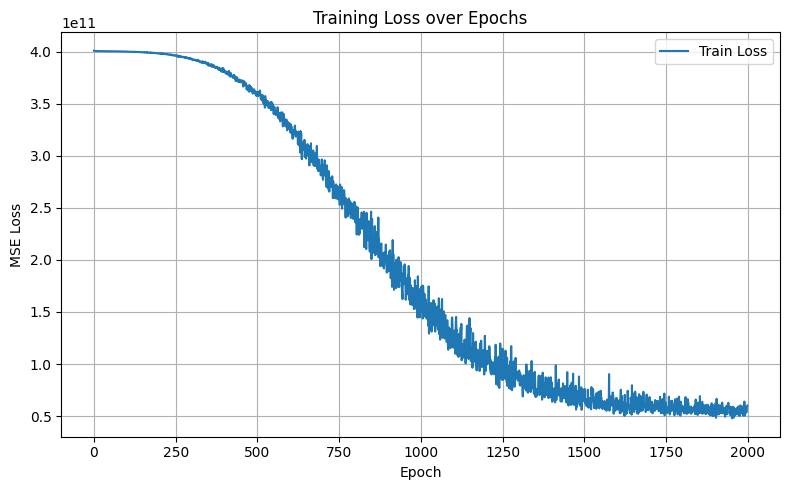

In [103]:
def train_and_evaluate_model_with_dataloader(X_train, y_train, X_test, y_test, input_dim, batch_size=32, n_epochs=100):
    # 创建DataLoader
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # 定义模型
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super(MLP, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_dim, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(64, 1)
            )
        
        def forward(self, x):
            return self.layers(x)

    model = MLP(input_dim=input_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # 训练过程
    train_losses = []
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.float())
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * X_batch.size(0)
        
        epoch_loss /= len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}")

    # 测试集评估
    model.eval()
    test_predictions = []
    test_true = []
    test_loss = 0.0
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch.float())
            test_loss += loss.item() * X_batch.size(0)
            test_predictions.append(outputs.squeeze().cpu().numpy())
            test_true.append(y_batch.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_predictions = np.concatenate(test_predictions)
    test_true = np.concatenate(test_true)
    
    mse = mean_squared_error(test_true, test_predictions)
    mae = mean_absolute_error(test_true, test_predictions)
    r2 = r2_score(test_true, test_predictions)
    # rmse = mean_squared_error(test_true, test_predictions)
    rmse = root_mean_squared_error(test_true, test_predictions)
    print("\nTest Dataset Results：")
    print(f" MSE Loss: {test_loss:.4f}")
    print(f" MAE: {mae:.4f}")

    print(f" RMSE: {rmse:.4f}")
    print(f" R^2:{r2:.4f}")

    # 🔍 画图
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        'train_losses': train_losses,
        'test_loss': test_loss,
        'test_predictions': test_predictions,
        'test_true': test_true,
        'mse': mse,
        'mae': mae,
    }

# 示例调用
# 假设你已经有了 X_train, y_train, X_test, y_test
results = train_and_evaluate_model_with_dataloader(X_train, y_train, X_test, y_test, input_dim=X_train.shape[1], batch_size=32, n_epochs=2000)
